# Stance detection with BERT
In this notebook, the task of stance detection is tackled using BERT to encode the examples of a stance detection datasets and using that representation for classification.

## Setup
Importing necessary modules and functions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np

In [3]:
from datasets import SemEval
from torch import nn, optim
from bert import encode
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.metrics import f1_score, classification_report
from math import ceil
from warnings import filterwarnings
from utils import plot_confusion_matrix, print_misclassifications, get_batch, save_state_dict

In [4]:
filterwarnings("ignore")

In [5]:
classifier_state_dict_name = "bert_classifier"

## Model definition
The following cells define the blueprint of the model employed for this task; a function to instantiate the model is also provided, ensuring that each time the same initialisation is performed to guarantee reproducibility.

In [6]:
class Model(nn.Module):
    
    def __init__(self, input_size, intermediate_size, target_size):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.ReLU(),
            nn.Linear(intermediate_size, target_size),
            nn.Softmax(dim=1)
        )
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def forward(self, inputs, labels=None):
        probabilities = self.classifier(inputs)
        return probabilities, torch.argmax(probabilities, 1), self.cross_entropy(probabilities, labels) if labels is not None else None

In [7]:
def get_model(state_dict=None):
    torch.manual_seed(42)
    model = Model(768, 64, 3).cuda()
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return model

## Loading and Encoding
In the following, the stance dataset is loaded and its texts and targets are encoded to form the inputs for the model.

In [8]:
training, testing = SemEval.get_subtask_a_datasets("data/semeval/")

In [9]:
training_inputs = encode(training.texts, training.targets, method="conditional-target", maximum_length=80).cuda(), torch.tensor(training.stances).cuda()
testing_inputs  = encode(testing.texts,  testing.targets,  method="conditional-target", maximum_length=80).cuda(), torch.tensor(testing.stances ).cuda()

## Training
The training environment is set up.

In [10]:
model = get_model()
batch_size = 48
optimiser = optim.Adam(model.parameters(), lr=1e-4)
step, steps_since, early_stopping = 0, 0, 1000
evaluation_function = lambda true, predicted: f1_score(true, predicted, average="macro")

In [11]:
optimal_score, optimal_model_state_dict = 0., None

In [12]:
training_loss, testing_loss = [], []

In [13]:
while steps_since < early_stopping:

    model.zero_grad()
    optimiser.zero_grad()
    model.train()

    inputs = get_batch(step, batch_size, training_inputs)
    _, _, loss = model(*inputs)
    training_loss.append(float(loss))

    loss.backward()
    optimiser.step()

    model.eval()

    _, predictions, loss = model(*testing_inputs)
    score = evaluation_function(testing.stances, predictions.cpu())
    testing_loss.append(float(loss))
    
    if score > optimal_score:
        optimal_score = score
        optimal_model_state_dict = deepcopy(model.state_dict())
        steps_since = 0
    else:
        steps_since += 1

    step += 1

In [14]:
save_state_dict(optimal_model_state_dict, classifier_state_dict_name)

## Evaluation
The training and testing loss is plotted; the optimal testing model is loaded and the evaluation metrics are computed; misclassifcations are printed.

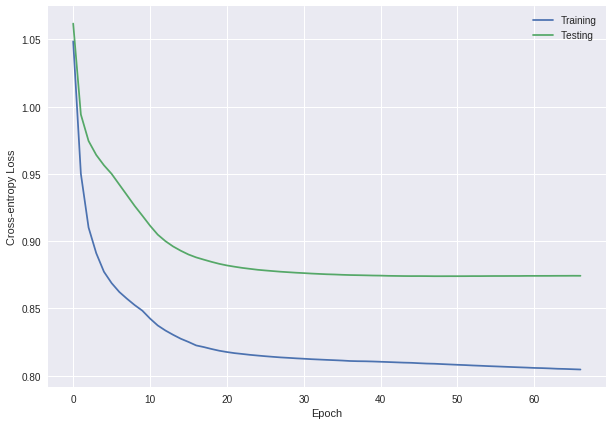

In [21]:
plt.style.use("seaborn")
plt.figure(figsize=(10, 7))
plt.plot(training_loss[::ceil(len(training) / batch_size)])
plt.plot(testing_loss[::ceil(len(training) / batch_size)])
plt.legend(["Training", "Testing"])
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy Loss")
pass

In [22]:
model = get_model(state_dict=optimal_model_state_dict)
model.eval()

Model(
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
    (3): Softmax()
  )
  (cross_entropy): CrossEntropyLoss()
)

In [23]:
_, predictions, _ = model(*testing_inputs)

In [24]:
print(classification_report(testing.stances, predictions.cpu()))

              precision    recall  f1-score   support

           0       0.52      0.66      0.58       230
           1       0.75      0.45      0.56       304
           2       0.72      0.78      0.75       715

    accuracy                           0.68      1249
   macro avg       0.66      0.63      0.63      1249
weighted avg       0.69      0.68      0.67      1249



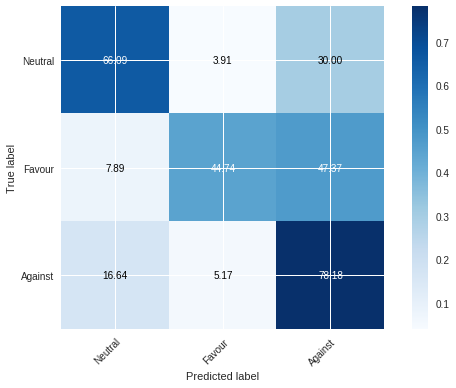

In [25]:
plot_confusion_matrix(testing.stances, predictions.cpu())

In [26]:
print_misclassifications(testing, predictions.cpu())

Text:		@David_Cameron   Miracles of #Multiculturalism   Miracles of shady 786  #Taqiya #Tawriya #Jaziya #Kafirs #Dhimmi #Jihad #Allah #SemST
Target:		Atheism
Stance:		Against
Prediction:	Neutral

Text:		This world needs a tight group hug. Tight enough to relieve them from all this anger and hate. #MakePeaceWithEachOther #SemST
Target:		Atheism
Stance:		Against
Prediction:	Neutral

Text:		@SecularDutchess I'll be your huckleberry @DeanModified #SemST
Target:		Atheism
Stance:		Against
Prediction:	Neutral

Text:		If only dreams were real, now it's gone. #SingleBecause #getonyourfeet #SemST
Target:		Atheism
Stance:		Against
Prediction:	Neutral

Text:		Happy Independence Day to America and her beautiful constitution #IndependenceDay #USA #SemST
Target:		Atheism
Stance:		Against
Prediction:	Neutral

Text:		These days, the cool kids are atheists.  #freethinker #SemST
Target:		Atheism
Stance:		Against
Prediction:	Favour

Text:		I am Baloch and I will not allow Talibanization in Balochistan ...